In [26]:
from mads_datasets.base import BaseDatastreamer
from mltrainer.preprocessors import BasePreprocessor
import matplotlib.pyplot as plt
from pathlib import Path
import pandas as pd
import seaborn as sns
from sklearn.metrics import confusion_matrix
from torch import nn
import torch
import numpy as np

from mads_hackathon import datasets, metrics
import mltrainer
import tomllib

In [27]:
configfile = Path("config.toml")
with configfile.open("rb") as f:
    tomlconfig = tomllib.load(f)

assert tomlconfig["dev"] != "dev", ValueError("Please set dev in config.toml to your own name")
assert tomlconfig["port"] != "none", ValueError("Please set port in config.toml to your own port")
uri = tomlconfig["mlflow_uri"] + ":" + tomlconfig["port"]
dev = tomlconfig["dev"]
print(f"Using {uri} as mlfow uri")
print(f"Using {dev} as dev name")

Using http://145.38.195.42:5002 as mlfow uri
Using dev-Sven as dev name


In [28]:
import torch
if torch.backends.mps.is_available() and torch.backends.mps.is_built():
    device = torch.device("mps")
    print("Using MPS")
elif torch.cuda.is_available():
    device = "cuda:0"
    print("using cuda")
else:
    device = "cpu"
    print("using cpu")

using cuda


In [29]:
datadir = Path('/home/svelthuis/Hackathon/group_c/hackathon-data/')
trainfile = (datadir / "heart_big_train.parq").resolve()
validfile = (datadir / "heart_big_valid.parq").resolve()
trainfile.exists(), validfile.exists()

(True, True)

In [30]:
import torch

train_df = pd.read_parquet(trainfile)
train_percentages = train_df.target.value_counts(normalize=True).sort_index() * 100
weights1 = torch.tensor((100.0 / train_percentages).to_numpy()).float().to(device)
weights2 = torch.tensor((1.0 / train_percentages).to_numpy()).float().to(device)
weights1, weights2

(tensor([  1.2081,  39.3855,  15.1268, 136.5897,  13.6144], device='cuda:0'),
 tensor([0.0121, 0.3939, 0.1513, 1.3659, 0.1361], device='cuda:0'))

Load the data

In [31]:
traindataset = datasets.HeartDataset1D_balanced(trainfile, target="target", samplingmethod="undersample")
validdataset = datasets.HeartDataset1D(validfile, target="target")
traindataset.to(device), validdataset.to(device)

# moving to mps device crashes the jypyter kernel, I wasnt able to fix that...

(None, None)

Visualise it as 1D data

torch.Size([192, 1]) tensor(0, device='cuda:0')


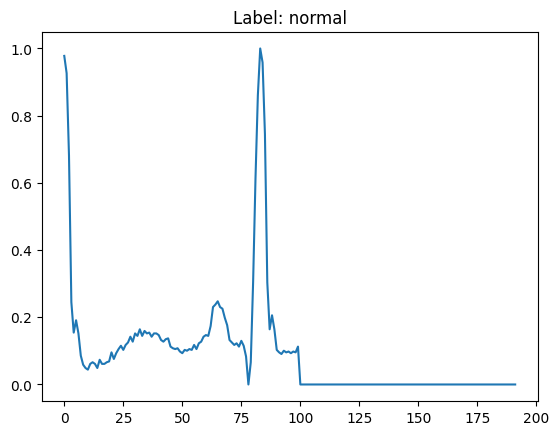

In [32]:
x, y = traindataset[0]
viz = x.squeeze().cpu().numpy()
sns.lineplot(x=range(len(viz)), y=viz)
title = 'normal' if y == 0 else 'abnormal'
plt.title(f"Label: {title}");
print(x.shape, y)

In [33]:
from mads_hackathon.models import TransformerConfig as Config

config = Config(
    batchsize=128,
    dropout=0.1,
    input_channels=1,
    hidden=64,
    kernel_size=3,
    stride=1,
    num_heads=2,
    num_blocks=2,
    num_classes=5,
)

Set up the streamer

In [34]:
trainstreamer = BaseDatastreamer(traindataset, preprocessor = BasePreprocessor(), batchsize=config.batchsize)
validstreamer = BaseDatastreamer(validdataset, preprocessor = BasePreprocessor(), batchsize=config.batchsize)
len(trainstreamer), len(validstreamer)

(684, 85)

Note, the layers have different assumptions about the data structure:
- streamer:         (batch, seq_len, channels)
- conv1d:           (batch, channels, seq_len)
- pos_encoding:     (batch, seq_len, channels)
- gru (batchfirst): (batch, seq_len, channels)
- attention:        (batch, seq_len, channels)

As you can see, its just the conv1d layer that expects channels as the second dimension. Using a conv1d layer you
will need to transpose the dimensions, I will show how to do that in the Transformer `forward` method.

Again, the strategy of creating a block helps us stack the architecture more easily.

In [35]:
from mads_hackathon.models import Transformer
model = Transformer(config)

In [36]:
x, y = next(trainstreamer.stream())
x.shape, y.shape

(torch.Size([128, 192, 1]), torch.Size([128]))

In [37]:
from torchinfo import summary

summary(model, input_size=x.shape)

Layer (type:depth-idx)                   Output Shape              Param #
Transformer                              [128, 5]                  --
├─Conv1d: 1-1                            [128, 64, 192]            256
├─PositionalEncoding: 1-2                [128, 192, 64]            --
│    └─Dropout: 2-1                      [128, 192, 64]            --
├─ModuleList: 1-3                        --                        --
│    └─TransformerBlock: 2-2             [128, 192, 64]            --
│    │    └─MultiheadAttention: 3-1      [128, 192, 64]            16,640
│    │    └─LayerNorm: 3-2               [128, 192, 64]            128
│    │    └─Sequential: 3-3              [128, 192, 64]            8,320
│    │    └─LayerNorm: 3-4               [128, 192, 64]            128
│    └─TransformerBlock: 2-3             [128, 192, 64]            --
│    │    └─MultiheadAttention: 3-5      [128, 192, 64]            16,640
│    │    └─LayerNorm: 3-6               [128, 192, 64]            128


In [38]:
model.to(device)
yhat = model(x)
yhat.shape

torch.Size([128, 5])

In [39]:
from mads_hackathon.metrics import caluclate_cfm
f1micro = metrics.F1Score(average='micro')
f1macro = metrics.F1Score(average='macro')
precision = metrics.Precision('micro')
recall = metrics.Recall('macro')
accuracy = metrics.Accuracy()

In [40]:
import mlflow
#mlflow.set_tracking_uri(uri)
#mlflow.set_experiment("Transformer")

2024-11-25 15:28:49.995 | INFO     | mltrainer.trainer:dir_add_timestamp:29 - Logging to logs/heart1D/20241125-152849
  0%|          | 0/5 [00:00<?, ?it/s]

100%|██████████| 684/684 [00:07<00:00, 90.84it/s]
2024-11-25 15:28:58.323 | INFO     | mltrainer.trainer:report:191 - Epoch 0 train 0.3793 test 0.2590 metric ['0.9210', '0.9210', '0.6646', '0.9210', '0.6782']
100%|██████████| 684/684 [00:07<00:00, 91.28it/s]
2024-11-25 15:29:06.617 | INFO     | mltrainer.trainer:report:191 - Epoch 1 train 0.2037 test 0.1665 metric ['0.9572', '0.9572', '0.7742', '0.9572', '0.7797']
100%|██████████| 684/684 [00:07<00:00, 90.83it/s]
2024-11-25 15:29:14.956 | INFO     | mltrainer.trainer:report:191 - Epoch 2 train 0.1675 test 0.1470 metric ['0.9616', '0.9616', '0.7897', '0.9616', '0.8167']
100%|██████████| 684/684 [00:07<00:00, 88.69it/s]
2024-11-25 15:29:23.486 | INFO     | mltrainer.trainer:report:191 - Epoch 3 train 0.1461 test 0.1410 metric ['0.9608', '0.9608', '0.8008', '0.9608', '0.8132']
100%|██████████| 684/684 [00:07<00:00, 89.73it/s]
2024-11-25 15:29:31.902 | INFO     | mltrainer.trainer:report:191 - Epoch 4 train 0.1322 test 0.1180 metric ['0.96

[Text(0.5, 23.52222222222222, 'Predicted'),
 Text(50.722222222222214, 0.5, 'Target')]

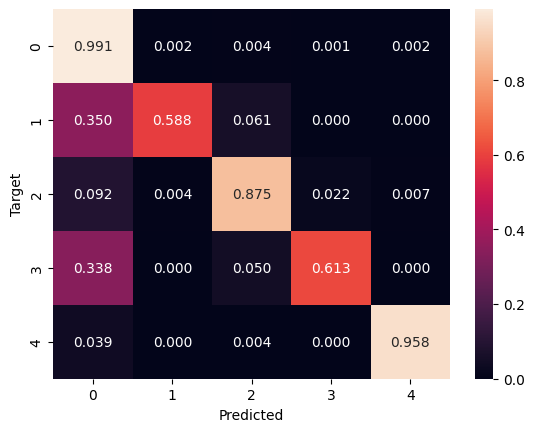

In [41]:
from mltrainer import Trainer, TrainerSettings, ReportTypes
from dataclasses import asdict

loss_fn = torch.nn.CrossEntropyLoss()

with mlflow.start_run():
    optimizer = torch.optim.Adam

    settings = TrainerSettings(
        epochs=5,
        metrics=[accuracy, f1micro, f1macro, precision, recall],
        logdir="logs/heart1D",
        train_steps=len(trainstreamer),
        valid_steps=len(validstreamer),
        reporttypes=[ReportTypes.TENSORBOARD, ReportTypes.MLFLOW],
        scheduler_kwargs=None,
        earlystop_kwargs=None
    )

    mlflow.set_tag("model", "Transfomer")
    mlflow.set_tag("dataset", "heart1D")
    mlflow.set_tag("dev", dev)
    mlflow.log_params(asdict(config))
    mlflow.log_param("epochs", settings.epochs)
    mlflow.log_param("optimizer", str(optimizer))
    mlflow.log_param("scheduler", "None")
    mlflow.log_param("earlystop", "None")
    mlflow.log_params(settings.optimizer_kwargs)

    trainer = Trainer(
        model=model,
        settings=settings,
        loss_fn=loss_fn,
        optimizer=optimizer,
        traindataloader=trainstreamer.stream(),
        validdataloader=validstreamer.stream(),
        scheduler=None,
        )
    trainer.loop()
    cfm = caluclate_cfm(model, validstreamer)
    for i, tp in enumerate(np.diag(cfm)):
        mlflow.log_metric(f"TP_{i}", tp)
plot = sns.heatmap(cfm, annot=cfm, fmt=".3f")
plot.set(xlabel="Predicted", ylabel="Target")

2024-11-25 15:29:32.488 | INFO     | mltrainer.trainer:dir_add_timestamp:29 - Logging to logs/heart1D/20241125-152932
  0%|          | 0/5 [00:00<?, ?it/s]

100%|██████████| 684/684 [00:07<00:00, 91.83it/s]
2024-11-25 15:29:40.735 | INFO     | mltrainer.trainer:report:191 - Epoch 0 train 0.3776 test 0.3603 metric ['0.8324', '0.8324', '0.6202', '0.8324', '0.8769']
100%|██████████| 684/684 [00:07<00:00, 89.01it/s]
2024-11-25 15:29:49.346 | INFO     | mltrainer.trainer:report:191 - Epoch 1 train 0.3621 test 0.3583 metric ['0.8973', '0.8973', '0.6815', '0.8973', '0.8722']
100%|██████████| 684/684 [00:07<00:00, 91.15it/s]
2024-11-25 15:29:57.636 | INFO     | mltrainer.trainer:report:191 - Epoch 2 train 0.3384 test 0.3778 metric ['0.8422', '0.8422', '0.6434', '0.8422', '0.8756']
100%|██████████| 684/684 [00:07<00:00, 91.23it/s]
2024-11-25 15:30:05.929 | INFO     | mltrainer.trainer:report:191 - Epoch 3 train 0.3297 test 0.3063 metric ['0.9141', '0.9141', '0.7064', '0.9141', '0.8838']
100%|██████████| 684/684 [00:07<00:00, 90.15it/s]
2024-11-25 15:30:14.311 | INFO     | mltrainer.trainer:report:191 - Epoch 4 train 0.3098 test 0.3390 metric ['0.86

[Text(0.5, 23.52222222222222, 'Predicted'),
 Text(50.722222222222214, 0.5, 'Target')]

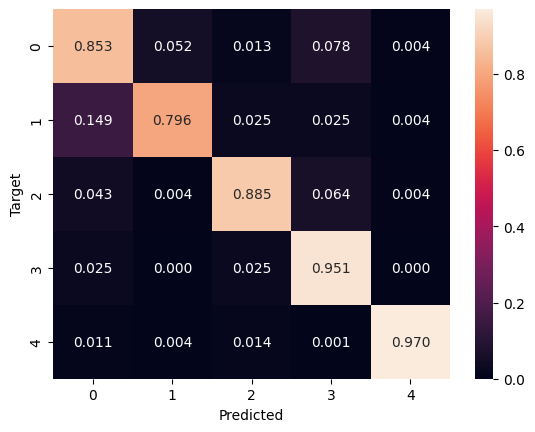

In [42]:
from mltrainer import Trainer, TrainerSettings, ReportTypes
from dataclasses import asdict

loss_fn = torch.nn.CrossEntropyLoss(weight=weights2)

with mlflow.start_run():
    optimizer = torch.optim.Adam

    settings = TrainerSettings(
        epochs=5,
        metrics=[accuracy, f1micro, f1macro, precision, recall],
        logdir="logs/heart1D",
        train_steps=len(trainstreamer),
        valid_steps=len(validstreamer),
        reporttypes=[ReportTypes.TENSORBOARD, ReportTypes.MLFLOW],
        scheduler_kwargs=None,
        earlystop_kwargs=None
    )

    mlflow.set_tag("model", "Transfomer")
    mlflow.set_tag("dataset", "heart1D")
    mlflow.set_tag("dev", dev)
    mlflow.log_params(asdict(config))
    mlflow.log_param("epochs", settings.epochs)
    mlflow.log_param("optimizer", str(optimizer))
    mlflow.log_param("scheduler", "None")
    mlflow.log_param("earlystop", "None")
    mlflow.log_params(settings.optimizer_kwargs)

    trainer = Trainer(
        model=model,
        settings=settings,
        loss_fn=loss_fn,
        optimizer=optimizer,
        traindataloader=trainstreamer.stream(),
        validdataloader=validstreamer.stream(),
        scheduler=None,
        )
    trainer.loop()
    cfm = caluclate_cfm(model, validstreamer)
    for i, tp in enumerate(np.diag(cfm)):
        mlflow.log_metric(f"TP_{i}", tp)
plot = sns.heatmap(cfm, annot=cfm, fmt=".3f")
plot.set(xlabel="Predicted", ylabel="Target")

2024-11-25 15:30:14.915 | INFO     | mltrainer.trainer:dir_add_timestamp:29 - Logging to logs/heart1D/20241125-153014


100%|██████████| 684/684 [00:07<00:00, 89.09it/s]
2024-11-25 15:30:23.402 | INFO     | mltrainer.trainer:report:191 - Epoch 0 train 0.3146 test 0.3119 metric ['0.8940', '0.8940', '0.6791', '0.8940', '0.8942']
100%|██████████| 684/684 [00:07<00:00, 91.15it/s]
2024-11-25 15:30:31.684 | INFO     | mltrainer.trainer:report:191 - Epoch 1 train 0.2969 test 0.3012 metric ['0.8847', '0.8847', '0.6668', '0.8847', '0.8934']
100%|██████████| 684/684 [00:07<00:00, 91.39it/s]
2024-11-25 15:30:39.958 | INFO     | mltrainer.trainer:report:191 - Epoch 2 train 0.2930 test 0.2942 metric ['0.8972', '0.8972', '0.7136', '0.8972', '0.9032']
100%|██████████| 684/684 [00:07<00:00, 91.22it/s]
2024-11-25 15:30:48.263 | INFO     | mltrainer.trainer:report:191 - Epoch 3 train 0.2807 test 0.3021 metric ['0.9104', '0.9104', '0.6977', '0.9104', '0.8959']
100%|██████████| 684/684 [00:07<00:00, 91.81it/s]
2024-11-25 15:30:56.506 | INFO     | mltrainer.trainer:report:191 - Epoch 4 train 0.2668 test 0.2861 metric ['0.90

[Text(0.5, 23.52222222222222, 'Predicted'),
 Text(50.722222222222214, 0.5, 'Target')]

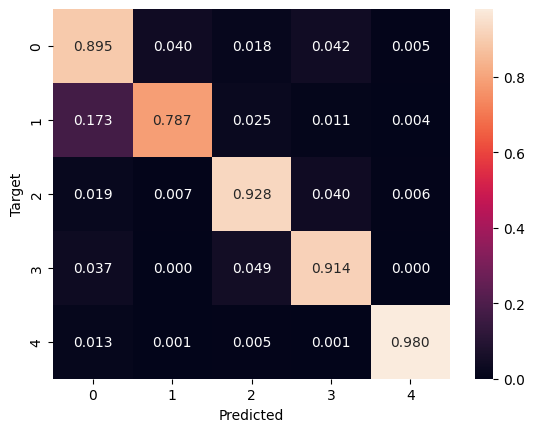

In [43]:
from mltrainer import Trainer, TrainerSettings, ReportTypes
from dataclasses import asdict

loss_fn = torch.nn.CrossEntropyLoss(weight=weights1)

with mlflow.start_run():
    optimizer = torch.optim.Adam

    settings = TrainerSettings(
        epochs=5,
        metrics=[accuracy, f1micro, f1macro, precision, recall],
        logdir="logs/heart1D",
        train_steps=len(trainstreamer),
        valid_steps=len(validstreamer),
        reporttypes=[ReportTypes.TENSORBOARD, ReportTypes.MLFLOW],
        scheduler_kwargs=None,
        earlystop_kwargs=None
    )

    mlflow.set_tag("model", "Transfomer")
    mlflow.set_tag("dataset", "heart1D")
    mlflow.set_tag("dev", dev)
    mlflow.log_params(asdict(config))
    mlflow.log_param("epochs", settings.epochs)
    mlflow.log_param("optimizer", str(optimizer))
    mlflow.log_param("scheduler", "None")
    mlflow.log_param("earlystop", "None")
    mlflow.log_params(settings.optimizer_kwargs)

    trainer = Trainer(
        model=model,
        settings=settings,
        loss_fn=loss_fn,
        optimizer=optimizer,
        traindataloader=trainstreamer.stream(),
        validdataloader=validstreamer.stream(),
        scheduler=None,
        )
    trainer.loop()
    cfm = caluclate_cfm(model, validstreamer)
    for i, tp in enumerate(np.diag(cfm)):
        mlflow.log_metric(f"TP_{i}", tp)
plot = sns.heatmap(cfm, annot=cfm, fmt=".3f")
plot.set(xlabel="Predicted", ylabel="Target")

[Text(0.5, 23.52222222222222, 'Predicted'),
 Text(50.722222222222214, 0.5, 'Target')]

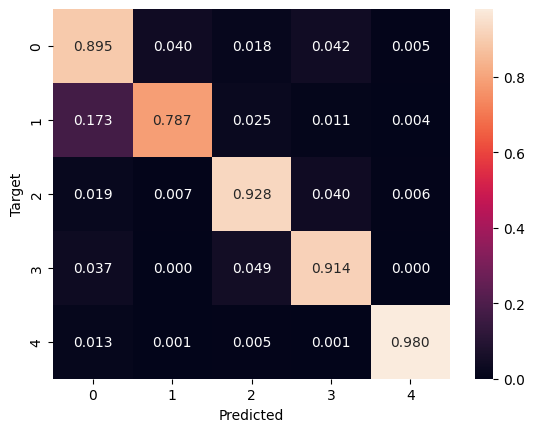

In [44]:
plot = sns.heatmap(cfm, annot=cfm, fmt=".3f")
plot.set(xlabel="Predicted", ylabel="Target")